## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
!pip install sklearn

## Load data

In [2]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In [3]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")
xy_train = pd.concat([x_train, y_train], axis=1)
xy_test = pd.concat([x_test, y_test], axis=1)
raw_xy_train = xy_train.values.tolist()
raw_xy_test = xy_train.values.tolist()

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from page 666 on the textbook

In [5]:
def gini(sequence):
    num_of_class_one = 0
    size = len(sequence)
    if size == 0:
        return 0
    for i in sequence:
        if i == 1:
            num_of_class_one += 1
    proportion = num_of_class_one / size
    return 1 - proportion ** 2 - (1 - proportion) ** 2

def entropy(sequence):
    num_of_class_one = 0
    size = len(sequence)
    if size == 0:
        return 0
    for i in sequence:
        if i == 1:
            num_of_class_one += 1
    proportion = num_of_class_one / size
    if proportion == 0:
        return 0
    return - proportion * math.log(proportion, 2) - proportion * math.log(proportion, 2)

In [6]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [7]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [8]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.8299157956468823


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [9]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None
        self.feature_importance = None
        
    def partition(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    
    def total_impurity(self, groups):
        g, y = [], []
        for group in groups:
            for i in range(len(group)):
                y.append(group[i][-1] + 1)
            if self.criterion == 'gini':
                g.append(gini(np.array(y)))
            else:
                g.append(entropy(np.array(y)))
        p = len(groups[0]) / (len(groups[0]) + len(groups[1]))
        return p * g[0] + (1 - p) * g[1]

    def find_best_split(self, dataset):
        best_feature, best_compare_num, lowest_impurity, best_groups = 0, 0, 999, None
        for feature in range(len(dataset[0]) - 1):
            for row in dataset:
                groups = self.partition(feature, row[feature], dataset)
                impurity = self.total_impurity(groups)
                if impurity < lowest_impurity:
                    best_feature, best_compare_num, lowest_impurity, best_groups = feature, row[feature], impurity, groups
        self.feature_importance[best_feature] += self.node_fi(dataset, best_groups)
        return {'feature': best_feature, 'value': best_compare_num, 'impurity': lowest_impurity, 'groups': best_groups}
    
    def leaf(self, group):
        classes = [row[-1] for row in group]
        return max(set(classes), key=classes.count)
    
    def split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.leaf(left + right)
            return
        if depth >= self.max_depth:
            node['left'], node['right'] = self.leaf(left), self.leaf(right)
            return
        node['left'] = self.find_best_split(left)
        self.split(node['left'], depth+1)
        node['right'] = self.find_best_split(right)
        self.split(node['right'], depth+1)

    def build_tree(self, dataset):
        self.feature_importance = np.zeros(len(dataset[0]) - 1)
        self.root = self.find_best_split(dataset)
        self.split(self.root, 1)
        return self.root

    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('%s[%s < %.3f]' % ((depth*' ', (feature_names[node['feature']]), node['value'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
        else:
            print('%s[%s]' % ((depth*' ', node)))

    def classify(self, node, row):
        if row[node['feature']] < node['value']:
            if isinstance(node['left'], dict):
                return self.classify(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.classify(node['right'], row)
            else:
                return node['right']
            
    def accuracy(self, dataset):
        correct = 0
        for row in dataset:
            result = self.classify(self.root, row)
            if result == row[-1]:
                correct += 1
        return correct / len(dataset)
    
    def node_fi(self, dataset, groups):
        father = gini([row[-1] for row in dataset]) * len(dataset)
        son1 = gini([row[-1] for row in groups[0]]) * len(groups[0])
        son2 = gini([row[-1] for row in groups[1]]) * len(groups[1])
        return father - son1 - son2
    
    def plot_fi(self):
        fi_dict = {k: self.feature_importance[v] for v, k in enumerate(feature_names)}
        fi_sorted_list = [i for i in (sorted(fi_dict.items(), key=lambda x:x[1])) if i[1] != 0]
        plt.barh(np.arange(len(fi_sorted_list)), [i[1] for i in fi_sorted_list])
        plt.yticks(np.arange(len(fi_sorted_list)), [i[0] for i in fi_sorted_list])
        plt.title("Feature Importance")
        plt.show()

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [10]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.build_tree(raw_xy_train)
print("accuracy: ", clf_depth3.accuracy(raw_xy_test))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.build_tree(raw_xy_train)
print("accuracy: ", clf_depth10.accuracy(raw_xy_test))

accuracy:  0.9178403755868545
accuracy:  1.0


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [11]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.build_tree(raw_xy_train)
print("accuracy: ", clf_gini.accuracy(raw_xy_test))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.build_tree(raw_xy_train)
print("accuracy: ", clf_entropy.accuracy(raw_xy_test))

accuracy:  0.9178403755868545
accuracy:  0.9178403755868545


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

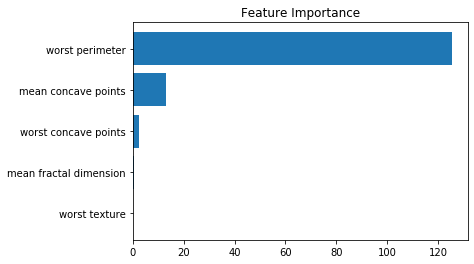

In [12]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.build_tree(raw_xy_test)
clf_gini.plot_fi()

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [13]:
class RandomForest(DecisionTree):
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=3):
        DecisionTree.__init__(self, criterion, max_depth)
        self.n_estimators = n_estimators
        self.max_features = math.floor(max_features)
        self.forest = None
    
    def find_best_split(self, dataset):
        best_feature, best_compare_num, lowest_impurity, best_groups = 0, 0, 999, None
        select_feature_list = random.sample(list(range(len(feature_names))), max_features)
        for feature in select_feature_list:
            for row in dataset:
                groups = self.partition(feature, row[feature], dataset)
                impurity = self.total_impurity(groups)
                if impurity < lowest_impurity:
                    best_feature, best_compare_num, lowest_impurity, best_groups = feature, row[feature], impurity, groups
        self.feature_importance[best_feature] += self.node_fi(dataset, best_groups)
        return {'feature': best_feature, 'value': best_compare_num, 'impurity': lowest_impurity, 'groups': best_groups}
    
    def build_forest(self, dataset):
        trees = []
        data_list = self.split_data(dataset)
        for i in range(self.n_estimators):
            clf = DecisionTree(self.criterion, self.max_depth)
            trees.append(clf.build_tree(data_list[i]))
        self.forest = trees
        return trees
    
    def print_forest(self, forest, depth=0):
        for i in range(self.n_estimators):
            self.print_tree(forest[i], depth=0)
        
    def split_data(self, dataset):
        data_list = list()
        for i in range(self.n_estimators):
            tmp_list = list()
            sample_amount = int(len(dataset) * 2 / 3)
            slist = random.sample(list(range(len(dataset))), sample_amount)
            for j in range(sample_amount):
                tmp_list.append(dataset[slist[j]])
            data_list.append(tmp_list)
        return data_list
    
    def accuracy(self, dataset):
        correct = 0
        for row in dataset:
            outcome = []
            for tree in self.forest:
                outcome.append(self.classify(tree, row))
            result = max(set(outcome), key=outcome.count)
            if result == row[-1]:
                correct += 1
        return correct / len(dataset)

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [14]:
clf_10tree = RandomForest(n_estimators=10, max_features=math.sqrt(x_train.shape[1]))
clf_10tree.build_forest(raw_xy_train)
print("accuracy: ", clf_10tree.accuracy(raw_xy_test))
clf_100tree = RandomForest(n_estimators=100, max_features=math.sqrt(x_train.shape[1]))
clf_100tree.build_forest(raw_xy_train)
print("accuracy: ", clf_10tree.accuracy(raw_xy_test))

accuracy:  0.9436619718309859
accuracy:  0.9436619718309859


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [15]:
clf_all_features = RandomForest(n_estimators=10, max_features=math.sqrt(x_train.shape[1]))
clf_all_features.build_forest(raw_xy_train)
print("accuracy: ", clf_all_features.accuracy(raw_xy_test))
clf_random_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_random_features.build_forest(raw_xy_train)
print("accuracy: ", clf_random_features.accuracy(raw_xy_test))

accuracy:  0.9436619718309859
accuracy:  0.9366197183098591


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 